📚 Ransomware Behavioral Detection — Autoencoder Modeling

In this notebook, we shift from CNNs and LSTMs to a new approach:

    Autoencoders → Unsupervised anomaly detection

Each row in our dataset represents a short execution window (0.1 seconds) with statistical features.
Ransomware does not instantly reveal itself → its behavior evolves gradually.

While CNNs capture local patterns and LSTMs model sequences → Autoencoders aim to:

✅ Compress patterns into latent space → keep essential, generalizable info
✅ Learn to reconstruct normal (benign) sequences well
✅ Fail to reconstruct ransomware patterns (since they were never seen) → → → Higher reconstruction error → anomaly detection

In other words:

    We will train the Autoencoder only on benign sequences → any sequence with high reconstruction error will be flagged as ransomware.

This notebook will:

    Build and train Autoencoder on benign sequences.

    Detect ransomware sequences based on reconstruction error.

    Focus on family-aware split → unseen families → zero-day scenario.

In [6]:
import os, random, numpy as np, pandas as pd, tensorflow as tf

SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

DATA_PATH = "final_prepared_dataset.parquet"  
df = pd.read_parquet(DATA_PATH)

print("Data shape:", df.shape)
df.head()          


Data shape: (194466, 26)


,family,window_id,read_throughput,read_lba_var,write_throughput,write_lba_var,write_entropy,mem_read_count_4k,mem_read_count_2m,mem_read_count_mmio,...,mem_readwrite_entropy,mem_readwrite_count_4k,mem_readwrite_count_2m,mem_readwrite_count_mmio,mem_readwrite_gpa_var,mem_exec_count_4k,mem_exec_count_2m,mem_exec_count_mmio,mem_exec_gpa_var,label
0,AESCrypt,0,0.0,0.0,0.0,0.0,0.0,0,6,314,...,0.749489,0,0,14,3.023757e+19,0,0,89,4.227084e+19,0
1,AESCrypt,1,0.0,0.0,0.0,0.0,0.0,0,0,214,...,0.843179,0,0,1,0.000000e+00,0,0,6,2.081018e+19,0
2,AESCrypt,2,0.0,0.0,0.0,0.0,0.0,0,0,20,...,0.643699,0,0,1,0.000000e+00,0,0,5,2.437121e+19,0
3,AESCrypt,5,0.0,0.0,0.0,0.0,0.0,0,0,9,...,0.837807,0,0,2,9.921287e+16,0,0,6,3.505556e+19,0
4,AESCrypt,6,0.0,0.0,0.0,0.0,0.0,0,0,1,...,0.000000,0,0,0,0.000000e+00,0,0,1,0.000000e+00,0


In [9]:
FEATURE_COLS = [c for c in df.columns if c not in ('label', 'family', 'window_id')]
X = df[FEATURE_COLS].values.astype(np.float32)
y = df['label'].values.astype(np.float32)

from sklearn.model_selection import train_test_split

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, stratify=y, random_state=SEED
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.15 / 0.85, stratify=y_temp, random_state=SEED
)  

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)
X_test  = scaler.transform(X_test)

print("Shapes — train:", X_train.shape, "val:", X_val.shape, "test:", X_test.shape)


Shapes — train: (136126, 23) val: (29170, 23) test: (29170, 23)


In [10]:
family_aware_split = {
    "train": ["Firefox", "Zip", "AESCrypt", "Idle"],
    "val":   ["SDelete", "WannaCry"],
    "test":  [ "Darkside", "Ryuk", "Office"],
}

train_mask = df.family.isin(family_aware_split["train"])
val_mask   = df.family.isin(family_aware_split["val"])
test_mask  = df.family.isin(family_aware_split["test"])

df_train = df.loc[train_mask]
df_val   = df.loc[val_mask]
df_test  = df.loc[test_mask]

X_tr  = df_train[FEATURE_COLS].values.astype(np.float32)
y_tr  = df_train["label"].values.astype(np.float32)

X_val = df_val[FEATURE_COLS].values.astype(np.float32)
y_val = df_val["label"].values.astype(np.float32)

X_test = df_test[FEATURE_COLS].values.astype(np.float32)
y_test = df_test["label"].values.astype(np.float32)

scaler = StandardScaler().fit(X_tr)
X_tr   = scaler.transform(X_tr)
X_val  = scaler.transform(X_val)
X_test = scaler.transform(X_test)

print("Family‑aware shapes — train:", X_tr.shape,
      "val:", X_val.shape, "test:", X_test.shape)


Family‑aware shapes — train: (70643, 23) val: (31820, 23) test: (40875, 23)


In [19]:

from tensorflow.keras import layers, Model, Input

LATENT_DIM = 24              
INPUT_DIM  = X_tr.shape[1]  

inp = Input(shape=(INPUT_DIM,), name="window_feats")
x   = layers.Dense(128, activation="relu")(inp)
x   = layers.Dense(64,  activation="relu")(x)
z   = layers.Dense(LATENT_DIM, activation="relu", name="latent")(x)  

x   = layers.Dense(64,  activation="relu")(z)
x   = layers.Dense(128, activation="relu")(x)
out = layers.Dense(INPUT_DIM, activation="linear")(x) 

autoencoder = Model(inp, out, name="AE_fc32")
autoencoder.compile(optimizer="adam", loss="mse")

encoder = Model(inp, z, name="encoder_fc32")

autoencoder.summary()


Model: "AE_fc32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ window_feats (InputLayer)       │ (None, 23)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 128)            │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent (Dense)                  │ (None, 24)             │         1,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 64)             │         1,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 23)             │         2,967 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,775 (100.68 KB)

 Trainable params: 25,775 (100.68 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
165/165 - 1s - 8ms/step - loss: 0.2946 - val_loss: 0.0461
Epoch 2/100
165/165 - 0s - 3ms/step - loss: 0.0425 - val_loss: 0.0236
Epoch 3/100
165/165 - 0s - 3ms/step - loss: 0.0278 - val_loss: 0.0187
Epoch 4/100
165/165 - 0s - 3ms/step - loss: 0.0254 - val_loss: 0.0171
Epoch 5/100
165/165 - 0s - 3ms/step - loss: 0.0228 - val_loss: 0.0146
Epoch 6/100
165/165 - 0s - 3ms/step - loss: 0.0192 - val_loss: 0.0159
Epoch 7/100
165/165 - 0s - 3ms/step - loss: 0.0131 - val_loss: 0.0115
Epoch 8/100
165/165 - 0s - 3ms/step - loss: 0.0122 - val_loss: 0.0122
Epoch 9/100
165/165 - 0s - 3ms/step - loss: 0.0145 - val_loss: 0.0098
Epoch 10/100
165/165 - 0s - 3ms/step - loss: 0.0144 - val_loss: 0.0093
Epoch 11/100
165/165 - 0s - 3ms/step - loss: 0.0153 - val_loss: 0.0112
Epoch 12/100
165/165 - 0s - 3ms/step - loss: 0.0152 - val_loss: 0.0088
Epoch 13/100
165/165 - 0s - 3ms/step - loss: 0.0104 - val_loss: 0.0070
Epoch 14/100
165/165 - 0s - 3ms/step - loss: 0.0077 - val_loss: 0.0074
Epoch 15/100
16

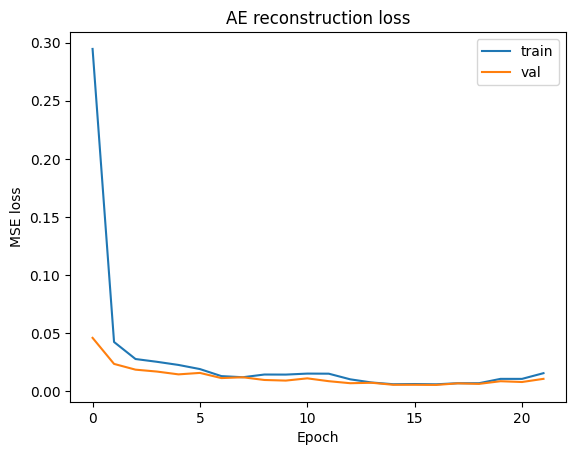

In [46]:
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

BATCH  = 512
EPOCHS = 100

es = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
    verbose=1
)

hist = autoencoder.fit(
    X_tr, X_tr,                
    validation_data=(X_val, X_val),
    epochs=EPOCHS,
    batch_size=BATCH,
    shuffle=True,
    callbacks=[es],
    verbose=2
)

plt.plot(hist.history["loss"], label="train")
plt.plot(hist.history["val_loss"], label="val")
plt.xlabel("Epoch"); plt.ylabel("MSE loss"); plt.legend(); plt.title("AE reconstruction loss");
plt.show()


In [47]:
from sklearn.metrics import classification_report, roc_auc_score, f1_score, precision_recall_fscore_support, confusion_matrix

def recon_error(x):                       
    recon = autoencoder.predict(x, verbose=0)
    return np.mean(np.square(x - recon), axis=1)

train_err = recon_error(X_tr)
val_err   = recon_error(X_val)
test_err  = recon_error(X_test_fam)

best_f1, best_thr = 0, None
for thr in np.percentile(val_err, np.linspace(50, 99.9, 200)):  
    preds = (val_err > thr).astype(int)     
    f1 = f1_score(y_val, preds)
    if f1 > best_f1:
        best_f1, best_thr = f1, thr

print(f"Chosen threshold: {best_thr:.4e}  (val F1={best_f1:.3f})")

test_preds = (test_err > best_thr).astype(int)

print("\nTest metrics (family‑aware):")
print(classification_report(y_test_fam, test_preds, digits=3))
print("Confusion matrix:\n", confusion_matrix(y_test_fam, test_preds))
print("ROC‑AUC:", roc_auc_score(y_test_fam, test_err))


Chosen threshold: 1.0413e-03  (val F1=0.653)

Test metrics (family‑aware):
              precision    recall  f1-score   support

         0.0      0.633     0.412     0.499     52348
         1.0      0.556     0.755     0.641     51128

    accuracy                          0.582    103476
   macro avg      0.594     0.584     0.570    103476
weighted avg      0.595     0.582     0.569    103476

Confusion matrix:
 [[21577 30771]
 [12533 38595]]
ROC‑AUC: 0.5787070696622366


Model: "AE_rand"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 23)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gaussian_noise_1                │ (None, 23)             │             0 │
│ (GaussianNoise)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 256)            │         6,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent (Dense)                  │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 23)             │         5,911 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 94,551 (369.34 KB)

 Trainable params: 94,551 (369.34 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
266/266 - 3s - 10ms/step - loss: 0.2056 - val_loss: 0.0637
Epoch 2/100
266/266 - 2s - 6ms/step - loss: 0.0796 - val_loss: 0.0851
Epoch 3/100
266/266 - 1s - 5ms/step - loss: 0.0621 - val_loss: 0.0483
Epoch 4/100
266/266 - 1s - 6ms/step - loss: 0.0790 - val_loss: 0.1322
Epoch 5/100
266/266 - 1s - 6ms/step - loss: 0.0647 - val_loss: 0.0738
Epoch 6/100
266/266 - 1s - 6ms/step - loss: 0.0576 - val_loss: 0.0493
Epoch 7/100
266/266 - 1s - 6ms/step - loss: 0.0793 - val_loss: 0.1099
Epoch 8/100
266/266 - 1s - 5ms/step - loss: 0.0608 - val_loss: 0.0807
Epoch 8: early stopping
Restoring model weights from the end of the best epoch: 3.


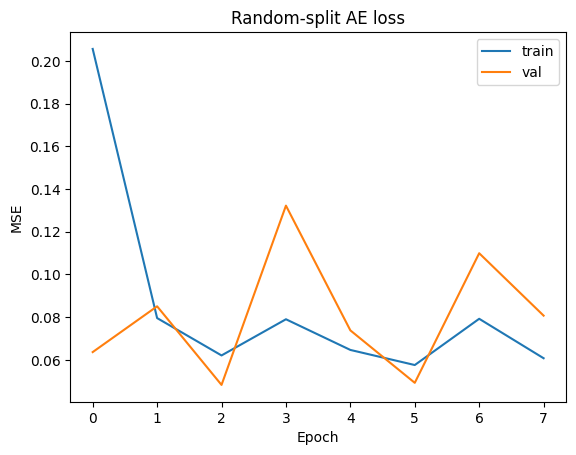


Chosen threshold = 2.7599e-03   (val F1 = 0.558)

Random‑split test metrics:
              precision    recall  f1-score   support

         0.0      0.167     0.010     0.018     13468
         1.0      0.667     0.976     0.793     27407

    accuracy                          0.658     40875
   macro avg      0.417     0.493     0.406     40875
weighted avg      0.502     0.658     0.538     40875

Confusion matrix:
 [[  131 13337]
 [  655 26752]]
ROC‑AUC: 0.5099825563393265


In [20]:
assert all(name in globals() for name in 
           ["X_train", "X_val", "X_test", "y_train", "y_val", "y_test"]), \
       "Run the random‑split‑creation cell first."

from tensorflow.keras import layers, Model, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import f1_score, classification_report, confusion_matrix, roc_auc_score
import numpy as np, matplotlib.pyplot as plt

SEED = 42
LATENT = 64
BATCH  = 512
EPOCHS = 100

inp = Input(shape=(X_train.shape[1],))
x   = layers.GaussianNoise(0.05)(inp)
x   = layers.Dense(256, activation="relu")(x)
#x   = layers.BatchNormalization()(x)
x   = layers.Dropout(0.2)(x)
x   = layers.Dense(128, activation="relu")(x)
#x   = layers.BatchNormalization()(x)
x   = layers.Dropout(0.2)(x)
z   = layers.Dense(LATENT, activation="relu", name="latent")(x)
                

x   = layers.Dense(128, activation="relu")(z)
#x   = layers.BatchNormalization()(x)
x   = layers.Dense(256, activation="relu")(x)
#x   = layers.BatchNormalization()(x)
out = layers.Dense(X_train.shape[1], activation="linear")(x)

ae_rand   = Model(inp, out, name="AE_rand")
encoder_r = Model(inp, z,   name="encoder_rand")
ae_rand.compile(optimizer="adam", loss="mse")
ae_rand.summary()

es = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1)
hist = ae_rand.fit(
    X_train, X_train,
    validation_data=(X_val, X_val),
    epochs=EPOCHS, batch_size=BATCH,
    shuffle=True, callbacks=[es], verbose=2
)

plt.plot(hist.history["loss"], label="train")
plt.plot(hist.history["val_loss"], label="val")
plt.title("Random‑split AE loss"); plt.xlabel("Epoch"); plt.ylabel("MSE"); plt.legend(); plt.show()

def recon_err(x): return np.mean(np.square(x - ae_rand.predict(x, verbose=0)), axis=1)

val_err  = recon_err(X_val)
best_f1, best_thr = -1, None
for thr in np.percentile(val_err, np.linspace(50, 99.9, 300)):
    f1 = f1_score(y_val, (val_err > thr).astype(int), zero_division=0)
    if f1 >= best_f1: best_f1, best_thr = f1, thr

print(f"\nChosen threshold = {best_thr:.4e}   (val F1 = {best_f1:.3f})")

test_err   = recon_err(X_test)
test_preds = (test_err > best_thr).astype(int)

print("\nRandom‑split test metrics:")
print(classification_report(y_test, test_preds, digits=3))
print("Confusion matrix:\n", confusion_matrix(y_test, test_preds))
print("ROC‑AUC:", roc_auc_score(y_test, test_err))


In [21]:
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score

encoder_r.trainable = False

lat_in   = Input(shape=(encoder_r.output_shape[1],))
x        = layers.Dense(32, activation="relu")(lat_in)
x        = layers.Dropout(0.3)(x)
logit    = layers.Dense(1, activation="sigmoid")(x)

clf_head = Model(lat_in, logit, name="latent_head")

inp       = encoder_r.input           
latent    = encoder_r(inp)            
out_class = clf_head(latent)

ae_clf = Model(inp, out_class, name="AE_latent_classifier")
ae_clf.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

ae_clf.summary()

es = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True, verbose=1)
hist_clf = ae_clf.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30, batch_size=512, shuffle=True,
    callbacks=[es], verbose=2
)

test_probs = ae_clf.predict(X_test, batch_size=1024, verbose=0).ravel()
test_preds = (test_probs > 0.5).astype(int)         

print("\nRandom‑split latent‑classifier metrics:")
print(classification_report(y_test, test_preds, digits=3))
print("Confusion matrix:\n", confusion_matrix(y_test, test_preds))
print("ROC‑AUC:", roc_auc_score(y_test, test_probs))
print("Val F1 (using 0.5 thr):", f1_score(y_val, (ae_clf.predict(X_val, verbose=0)>0.5).astype(int)))


Model: "AE_latent_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 23)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_rand (Functional)       │ (None, 64)             │        47,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_head (Functional)        │ (None, 1)              │         2,113 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,409 (193.00 KB)

 Trainable params: 2,113 (8.25 KB)

 Non-trainable params: 47,296 (184.75 KB)

Epoch 1/30
266/266 - 1s - 5ms/step - accuracy: 0.6728 - loss: 0.6223 - val_accuracy: 0.7015 - val_loss: 0.6140
Epoch 2/30
266/266 - 1s - 3ms/step - accuracy: 0.7083 - loss: 0.5748 - val_accuracy: 0.7086 - val_loss: 0.5943
Epoch 3/30
266/266 - 1s - 3ms/step - accuracy: 0.7187 - loss: 0.5559 - val_accuracy: 0.7128 - val_loss: 0.5871
Epoch 4/30
266/266 - 1s - 3ms/step - accuracy: 0.7243 - loss: 0.5449 - val_accuracy: 0.7092 - val_loss: 0.5882
Epoch 5/30
266/266 - 1s - 3ms/step - accuracy: 0.7281 - loss: 0.5366 - val_accuracy: 0.6976 - val_loss: 0.5883
Epoch 6/30
266/266 - 1s - 3ms/step - accuracy: 0.7315 - loss: 0.5317 - val_accuracy: 0.6759 - val_loss: 0.5950
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 3.

Random‑split latent‑classifier metrics:
              precision    recall  f1-score   support

         0.0      0.559     0.704     0.623     13468
         1.0      0.833     0.727     0.776     27407

    accuracy                          0.719   

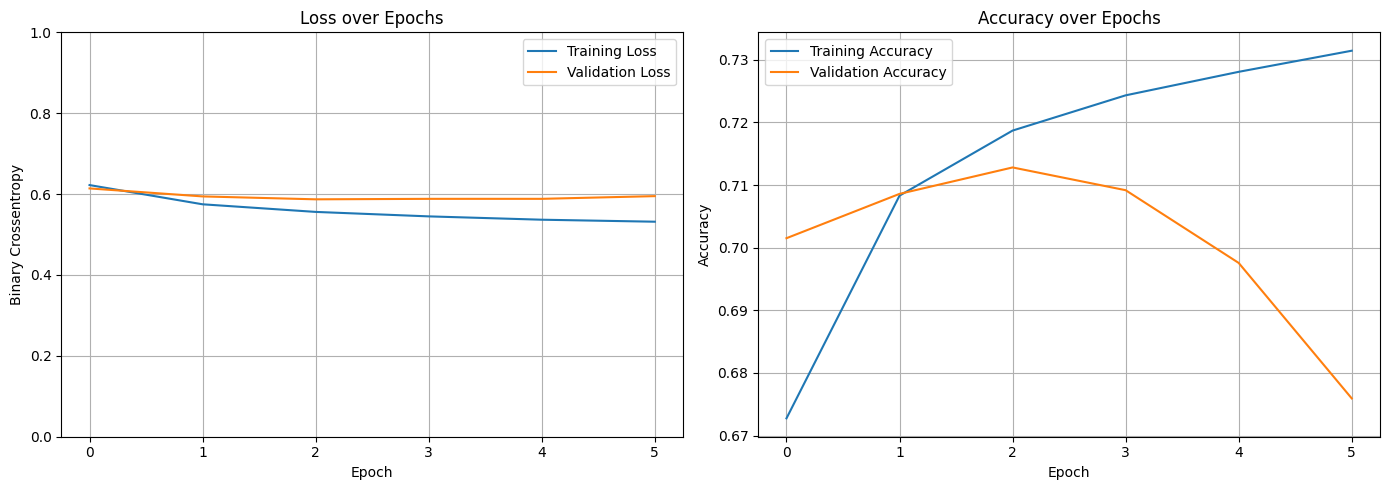

In [25]:
import matplotlib.pyplot as plt

history = hist_clf.history

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot Loss
ax1.plot(history['loss'], label='Training Loss')
ax1.plot(history['val_loss'], label='Validation Loss')
ax1.set_title('Loss over Epochs')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Binary Crossentropy')
ax1.set_ylim(0, 1)
ax1.legend()
ax1.grid(True)

# Plot Accuracy
ax2.plot(history['accuracy'], label='Training Accuracy')
ax2.plot(history['val_accuracy'], label='Validation Accuracy')
ax2.set_title('Accuracy over Epochs')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax1.set_ylim(0, 1)
ax2.legend()
ax2.grid(True)

# Final layout
plt.tight_layout()
plt.show()


In [13]:


from tensorflow.keras import regularizers 
family_aware_folds = {
    1: {
        "train_families": ['LockBit', 'WannaCry', 'Office', 'Zip', 'SDelete', 'AESCrypt'],
        "val_families":   ['Firefox', 'Ryuk', 'Darkside']
    },
    2: {
        "train_families": ['Conti', 'Firefox', 'Idle', 'LockBit', 'REvil', 'Ryuk'],
        "val_families":   ['Darkside', 'Office', 'Zip']
    },
    3: {
        "train_families": ['Darkside', 'Firefox', 'Office', 'REvil', 'Ryuk', 'Zip'],
        "val_families":   ['Conti', 'LockBit', 'Idle']
    }
}
FOLD_NUMBER   = 1
test_families = ['Conti', 'Idle', 'REvil']  

fold          = family_aware_folds[FOLD_NUMBER]
train_mask    = df.family.isin(fold["train_families"])
val_mask      = df.family.isin(fold["val_families"])
test_mask     = df.family.isin(test_families)

df_train, df_val, df_test = df[train_mask], df[val_mask], df[test_mask]

X_tr  = df_train[FEATURE_COLS].values.astype(np.float32)
y_tr  = df_train["label"].values.astype(np.float32)
X_val = df_val  [FEATURE_COLS].values.astype(np.float32)
y_val = df_val  ["label"].values.astype(np.float32)
X_ts  = df_test [FEATURE_COLS].values.astype(np.float32)
y_ts  = df_test ["label"].values.astype(np.float32)

scaler = StandardScaler().fit(X_tr)
X_tr, X_val, X_ts = scaler.transform(X_tr), scaler.transform(X_val), scaler.transform(X_ts)

from tensorflow.keras import layers, Model, Input
from tensorflow.keras.callbacks import EarlyStopping
SEED, LATENT, BATCH, EPOCHS = 42, 64, 512, 100

inp = Input(shape=(X_tr.shape[1],))
x   = layers.GaussianNoise(0.05)(inp)
x   = layers.Dense(256, activation="relu")(x); x = layers.BatchNormalization()(x); x = layers.Dropout(0.2)(x)
x   = layers.Dense(128, activation="relu")(x); x = layers.BatchNormalization()(x); x = layers.Dropout(0.2)(x)
z   = layers.Dense(LATENT, activation="relu", name="latent",
                   activity_regularizer=regularizers.l1(1e-5))(x)
x   = layers.Dense(128, activation="relu")(z); x = layers.BatchNormalization()(x)
x   = layers.Dense(256, activation="relu")(x); x = layers.BatchNormalization()(x)
out = layers.Dense(X_tr.shape[1], activation="linear")(x)

ae_fam   = Model(inp, out, name=f"AE_fold{FOLD_NUMBER}")
encoder  = Model(inp, z,   name=f"encoder_fold{FOLD_NUMBER}")
ae_fam.compile(optimizer="adam", loss="mse")

ae_fam.summary()

es = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1)
ae_fam.fit(X_tr, X_tr,
           validation_data=(X_val, X_val),
           epochs=EPOCHS, batch_size=BATCH, shuffle=True,
           callbacks=[es], verbose=2)

encoder.trainable = False
lat_in   = Input(shape=(LATENT,))
h        = layers.Dense(32, activation="relu")(lat_in)
h        = layers.Dropout(0.3)(h)
logit    = layers.Dense(1, activation="sigmoid")(h)
clf_head = Model(lat_in, logit, name="head")

inp2 = encoder.input
out2 = clf_head(encoder(inp2))
ae_clf = Model(inp2, out2, name=f"AE_fold{FOLD_NUMBER}_clf")
ae_clf.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

es_clf = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True, verbose=1)
ae_clf.fit(X_tr, y_tr,
           validation_data=(X_val, y_val),
           epochs=30, batch_size=512, shuffle=True,
           callbacks=[es_clf], verbose=2)

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score
test_probs = ae_clf.predict(X_ts, batch_size=1024, verbose=0).ravel()
test_preds = (test_probs > 0.5).astype(int)

print("\nFold‑1 family‑aware test metrics (0.5 thr):")
print(classification_report(y_ts, test_preds, digits=3))
print("Confusion matrix:\n", confusion_matrix(y_ts, test_preds))
print("ROC‑AUC:", roc_auc_score(y_ts, test_probs))

val_probs = ae_clf.predict(X_val, batch_size=1024, verbose=0).ravel()
best_f1, best_thr = -1, None
for thr in np.percentile(val_probs, np.linspace(0, 100, 201)):
    f1 = f1_score(y_val, (val_probs > thr).astype(int), zero_division=0)
    if f1 >= best_f1: best_f1, best_thr = f1, thr
print(f"\nBest val F1 = {best_f1:.3f} at thr = {best_thr:.3f}")

test_adj_preds = (test_probs > best_thr).astype(int)
print("Test F1 @ best thr:", f1_score(y_ts, test_adj_preds))


Model: "AE_fold1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 23)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gaussian_noise (GaussianNoise)  │ (None, 23)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │         6,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent (Dense)                  │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 23)             │         5,911 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 97,623 (381.34 KB)

 Trainable params: 96,087 (375.34 KB)

 Non-trainable params: 1,536 (6.00 KB)

Epoch 1/100
198/198 - 4s - 18ms/step - loss: 0.5125 - val_loss: 0.1894
Epoch 2/100
198/198 - 2s - 8ms/step - loss: 0.2551 - val_loss: 0.1434
Epoch 3/100
198/198 - 2s - 8ms/step - loss: 0.1960 - val_loss: 0.1322
Epoch 4/100
198/198 - 2s - 8ms/step - loss: 0.1720 - val_loss: 0.1199
Epoch 5/100
198/198 - 2s - 8ms/step - loss: 0.1479 - val_loss: 0.0985
Epoch 6/100
198/198 - 2s - 8ms/step - loss: 0.1246 - val_loss: 0.1183
Epoch 7/100
198/198 - 2s - 10ms/step - loss: 0.1105 - val_loss: 0.0772
Epoch 8/100
198/198 - 2s - 9ms/step - loss: 0.1103 - val_loss: 0.1086
Epoch 9/100
198/198 - 2s - 8ms/step - loss: 0.0954 - val_loss: 0.0818
Epoch 10/100
198/198 - 2s - 9ms/step - loss: 0.0940 - val_loss: 0.0836
Epoch 11/100
198/198 - 2s - 9ms/step - loss: 0.0861 - val_loss: 0.0815
Epoch 12/100
198/198 - 2s - 8ms/step - loss: 0.0822 - val_loss: 0.0953
Epoch 12: early stopping
Restoring model weights from the end of the best epoch: 7.
Epoch 1/30
198/198 - 2s - 9ms/step - accuracy: 0.6985 - loss: 0.6273 - 

In [15]:
ae_fam_history = ae_fam.fit(
    X_tr, X_tr,
    validation_data=(X_val, X_val),
    epochs=EPOCHS, batch_size=BATCH, shuffle=True,
    callbacks=[es], verbose=2
)

ae_clf_history = ae_clf.fit(
    X_tr, y_tr,
    validation_data=(X_val, y_val),
    epochs=30, batch_size=512, shuffle=True,
    callbacks=[es_clf], verbose=2
)


Epoch 1/100
198/198 - 2s - 8ms/step - loss: 0.1088 - val_loss: 0.1313
Epoch 2/100
198/198 - 2s - 8ms/step - loss: 0.0988 - val_loss: 0.0825
Epoch 3/100
198/198 - 2s - 8ms/step - loss: 0.0941 - val_loss: 0.0683
Epoch 4/100
198/198 - 2s - 8ms/step - loss: 0.0935 - val_loss: 0.0958
Epoch 5/100
198/198 - 2s - 8ms/step - loss: 0.0776 - val_loss: 0.0877
Epoch 6/100
198/198 - 2s - 8ms/step - loss: 0.0786 - val_loss: 0.1117
Epoch 7/100
198/198 - 2s - 8ms/step - loss: 0.0854 - val_loss: 0.0905
Epoch 8/100
198/198 - 2s - 9ms/step - loss: 0.0725 - val_loss: 0.0657
Epoch 9/100
198/198 - 2s - 8ms/step - loss: 0.0658 - val_loss: 0.0608
Epoch 10/100
198/198 - 2s - 8ms/step - loss: 0.0638 - val_loss: 0.0536
Epoch 11/100
198/198 - 2s - 8ms/step - loss: 0.0630 - val_loss: 0.0699
Epoch 12/100
198/198 - 2s - 8ms/step - loss: 0.0635 - val_loss: 0.0839
Epoch 13/100
198/198 - 2s - 8ms/step - loss: 0.0616 - val_loss: 0.0645
Epoch 14/100
198/198 - 2s - 8ms/step - loss: 0.0657 - val_loss: 0.1360
Epoch 15/100
19

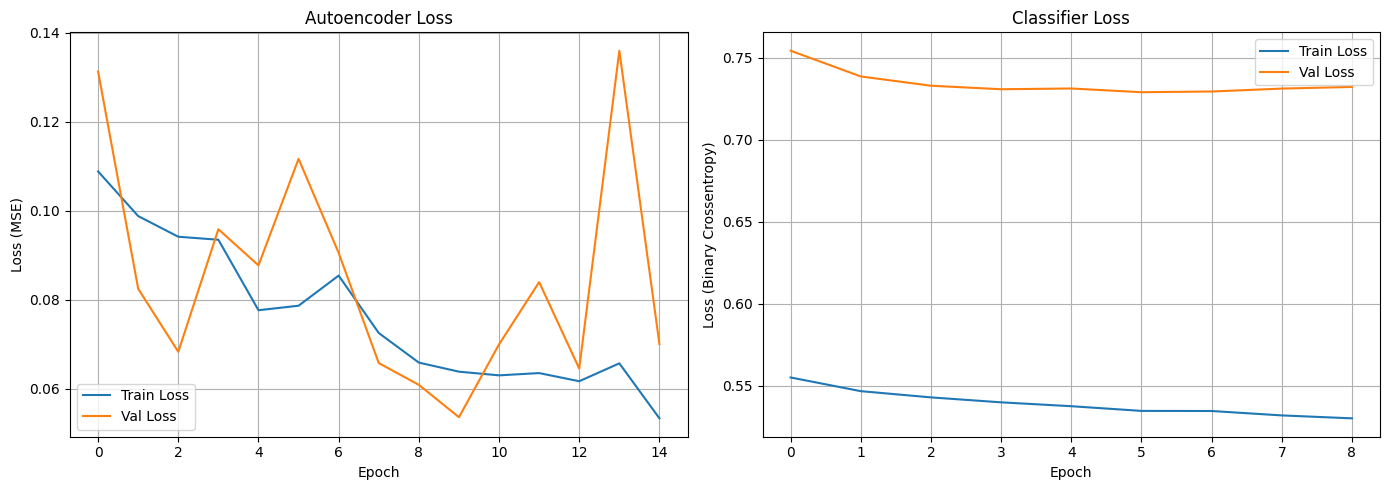

In [17]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

axs[0].plot(ae_fam_history.history['loss'], label='Train Loss')
axs[0].plot(ae_fam_history.history['val_loss'], label='Val Loss')
axs[0].set_title('Autoencoder Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss (MSE)')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(ae_clf_history.history['loss'], label='Train Loss')
axs[1].plot(ae_clf_history.history['val_loss'], label='Val Loss')
axs[1].set_title('Classifier Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss (Binary Crossentropy)')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()
